# How to Join Attributes from 1 shapefile to Another Using Geopandas

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Set work dir & get data
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

# Import data
data_path = os.path.join("data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa",
                                             "usa-boundary-dissolved.shp"))

state_bound_us = gpd.read_file(os.path.join(data_path, "usa",
                                           "usa-states-census-2014.shp"))

pop_places = gpd.read_file(os.path.join(data_path, "global",
                                       "ne_110m_populated_places_simple",
                                       "ne_110m_populated_places_simple.shp"))

ne_roads = gpd.read_file(os.path.join(data_path, "global",
                                     "ne_10m_roads", "ne_10m_roads.shp"))

Next dissolve the state data by region.

In [7]:
# Simplify the country boundary just a little bit to make this run faster
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

# Clip the roads to the US boundary
roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

# Dissolve states by region
regions_agg = state_bound_us.dissolve(by="region")

c:\programdata\miniconda3\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


## Spatial Joins

A spatial join is when you append the attributes of 1 layer to another based upon its spatial relationship

So - for example if you have the roads layer for the US; and you want to apply the "region" attribute to every road that is spatially in a particular region, you would use a spatial join. To apply a join you can use the geopandas.sjoin() function:

.sjoin(layer-to-add-region-to, region-polygon-layer)

### Sjoin Arguments:

The op argument specifies the type of join that will be applied
- intersects: Returns True if the boundary and interior of the object intersect in any way with those of the other.
- within: Returns True if the object's boundary and interior intersect only with the interior of the other (not its boundary or exterior).
- contains: Return True if the object's boundary and interior intersect only with the interior of the other (not its boundary or exterior).
-
Here are the following options:
- "left": use keys from left_df; retain only left_df geometry column
- "right": use keys from right_df; retain only right_df geometry column
- "inner": use intersection o0f keys from both dfs; retain only left_df geometry column

In [9]:
# Roads within region
roads_region = gpd.sjoin(roads_cl,
                        regions_agg,
                        how="inner",
                        op="intersects")

# Notice once you have joins the data - you have attributes
# From the regions_object (i.e. the region) attached to each raod feature
roads_region[["featurecla", "index_right", "ALAND"]].head()

,featurecla,index_right,ALAND
1,Road,Midwest,143794747023
3,Road,Midwest,143794747023
6,Road,Midwest,143794747023
7,Road,Midwest,143794747023
54,Road,Midwest,143794747023


Plot the data

c:\programdata\miniconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\programdata\miniconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


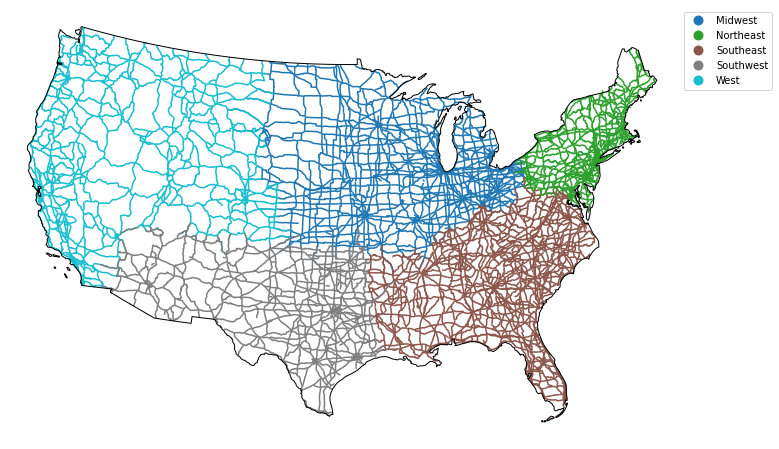

In [11]:
# Reproject to Albers for plotting
country_albers = country_bound_us.to_crs({"init": "epsg:5070"})
roads_albers = roads_region.to_crs({"init": "epsg:5070"})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                   facecolor="none",
                   edgecolor="black",
                   zorder=10,
                   ax=ax)

roads_albers.plot(column="index_right",
                 ax=ax,
                 legend=True)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 1))

ax.set_axis_off()
plt.axis("equal")
plt.show()

If you want to customise your legend even further, you can use loops to do so.

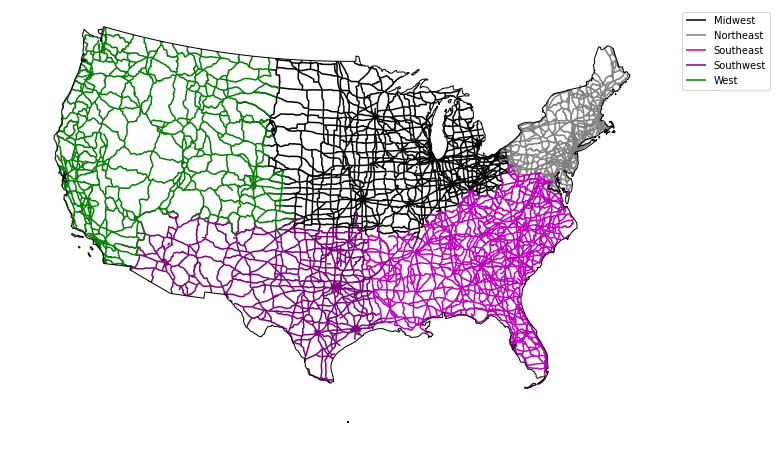

In [15]:
# 1st, create a dictionary with the attributes of each legend item
road_attrs = {"Midwest": ["black"],
             "Northeast": ["grey"],
             "Southeast": ["m"],
             "Southwest": ["purple"],
             "West": ["green"]}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                ax=ax)

country_albers.plot(alpha=1,
                   facecolor="none",
                   edgecolor="black",
                   zorder=10,
                   ax=ax)

for ctype, data in roads_albers.groupby("index_right"):
    data.plot(color=road_attrs[ctype][0],
             label=ctype,
             ax=ax)
    
# This approach works ot place the legend when you have defined labels
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis("equal")
plt.show()

## Calculate line segment length

In [16]:
# Turn off scientific notation
pd.options.display.float_format = "{:.4f}".format

# Calculate the total length of road
road_albers_length = roads_albers[["index_right", "length_km"]]

# Sum existing columns
roads_albers.groupby("index_right").sum()

roads_albers["rdlength"] = roads_albers.length
sub = roads_albers[["rdlength", "index_right"]].groupby("index_right").sum()
sub

,rdlength
index_right,
Midwest,86574994.9355
Northeast,33786044.0479
Southeast,84343052.6802
Southwest,49373105.6594
West,61379832.3913
